In [125]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, roc_auc_score, recall_score, precision_score

In [53]:
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

## Prepare

In [232]:
df = pd.read_csv('./Indonesian Tweets COVID-19 Handling (2020)/csv/positive-negative-only.csv', names=['tweet', 'label'])

In [233]:
df.head()

,tweet,label
0,Yuppp Karena UTANG Pemerintah jg UTANG Bangsa ...,neg
1,Yuks.. kawal kebijakan pemerintah jangan sampa...,pos
2,Yukk sama-sama bahu membahu membantuu pemerint...,pos
3,Yuk sahabat kita samasama menjaga jarak antar ...,pos
4,Yuk sahabat kita sama sama menjaga jarak antar...,pos


## Preprocess

In [234]:
# remove blank 
df = df[df['tweet'].notnull()]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1918 entries, 0 to 1917
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tweet   1918 non-null   object
 1   label   1918 non-null   object
dtypes: object(2)
memory usage: 30.1+ KB


In [235]:
# lower case
df['tweet'] = df['tweet'].apply(lambda x: x.lower())
df.head()

,tweet,label
0,yuppp karena utang pemerintah jg utang bangsa ...,neg
1,yuks.. kawal kebijakan pemerintah jangan sampa...,pos
2,yukk sama-sama bahu membahu membantuu pemerint...,pos
3,yuk sahabat kita samasama menjaga jarak antar ...,pos
4,yuk sahabat kita sama sama menjaga jarak antar...,pos


In [258]:
# remove non-alphabetic characters
import re

def regexPreprocessor(tweet):
    # Remove Non-ascii
    res = re.sub(r'[^\x00-\x7F]+',' ', tweet)

    # Remove url
    res = re.sub(r'http[s]?\:\/\/.[a-zA-Z0-9\.\/\_?=%&#\-\+!]+',' ', res)
    res = re.sub(r'pic.twitter.com?.[a-zA-Z0-9\.\/\_?=%&#\-\+!]+',' ', res)
    # Remove mention
    res = re.sub(r'\@([\w]+)',' ', res)
    
    # Remove hashtag
    # res = re.sub(r'\#([\w]+)',' ', res)
    # Proccessing hashtag (split camel case)   
    res = re.sub(r'((?<=[a-z])[A-Z]|[A-Z](?=[a-z]))', ' \\1', res)
    #res = re.sub(r'([A-Z])(?<=[a-z]\1|[A-Za-z]\1(?=[a-z]))',' \\1', res)
    
    
    # Remove special character
    res = re.sub(r'[!$%^&*@#()_+|~=`{}\[\]%\-:";\'<>?,.\/]', ' ', res)
    # Remove number
    res = re.sub(r'[0-9]+','', res)
    # Remove consecutive alphabetic characters
    res = re.sub(r'([a-zA-Z])\1\1','\\1', res)
    # Remove consecutive whitespace
    res = re.sub(' +', ' ', res)
    # Remove trailing and leading whitespace
    res = re.sub(r'^[ ]|[ ]$','', res)
    
    # Convert to lower case
    res = res.lower()

# df['tweet'] = df['tweet'].apply(regexPreprocessor)
# df.head()

In [237]:
# Tokenization using NLTK

def tokenize(tweet):
    return word_tokenize(tweet)

# df['tweet'] = df['tweet'].apply(tokenize)
# df.head()

In [238]:
# Stopwords removal
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
factory = StopWordRemoverFactory()

stopwords = factory.get_stop_words()

def remove_stopwords(tweet):
    return [word for word in tweet if word not in stopwords]

# df['tweet'] = df['tweet'].apply(remove_stopwords)
# df.head()


In [239]:
# Stemming using Sastrawi
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
factory = StemmerFactory()

stemmer = factory.create_stemmer()

def stemming(tweet):
    return [stemmer.stem(word) for word in tweet]


In [240]:
# Vectorization with TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    analyzer='word',
    preprocessor=regexPreprocessor,
    tokenizer=tokenize,
    lowercase=True,
    stop_words=stopwords,
    max_features=1000,
    ngram_range=(1, 1)
    )
# join tokens back to form strings so can be used in pipeline
# x = df['tweet'].apply(lambda x: ' '.join(x))
# # x = vectorizer.fit_transform(df['tweet'].apply(lambda x: ' '.join(x)))
# y = df['label']

## ML

In [242]:
# Splitting dataset
x_train, x_test, y_train, y_test = train_test_split(df['tweet'], df['label'], test_size=0.2, random_state=42, stratify=df['label'])

In [243]:
# Encoding label
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

In [210]:
kfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

In [211]:
# Train SVM model
np.random.seed(1)

pipeline_svm = make_pipeline(vectorizer, 
                            SVC(probability=True, kernel="linear", class_weight="balanced"))

grid_svm = GridSearchCV(pipeline_svm,
                    param_grid = {'svc__C': [0.01, 0.1, 1]}, 
                    cv = kfolds,
                    scoring="roc_auc",
                    verbose=1,   
                    n_jobs=-1) 

grid_svm.fit(x_train, y_train_encoded)
grid_svm.score(x_test, y_test_encoded)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


/home/surya/Code/Sentiment/.venv/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/surya/Code/Sentiment/.venv/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/surya/Code/Sentiment/.venv/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/surya/Code/Sentiment/.venv/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/surya/Code/Sentiment/.venv/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be use

/home/surya/Code/Sentiment/.venv/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/surya/Code/Sentiment/.venv/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/surya/Code/Sentiment/.venv/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/surya/Code/Sentiment/.venv/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


0.8577717019822282

## Evaluation

In [218]:
def report_results(model, X, y):
    pred_proba = model.predict_proba(X)[:, 1]
    pred = model.predict(X)        

    auc = roc_auc_score(y, pred_proba)
    acc = accuracy_score(y, pred)
    f1 = f1_score(y, pred)
    prec = precision_score(y, pred)
    rec = recall_score(y, pred)
    result = {'auc': auc, 'f1': f1, 'acc': acc, 'precision': prec, 'recall': rec}
    return result


In [219]:
report_results(grid_svm.best_estimator_, x_test, y_test_encoded)

{'auc': 0.8577717019822282,
 'f1': 0.7536231884057971,
 'acc': 0.7786458333333334,
 'precision': 0.7647058823529411,
 'recall': 0.7428571428571429}

In [214]:
def get_roc_curve(model, X, y):
    pred_proba = model.predict_proba(X)[:, 1]
    fpr, tpr, _ = roc_curve(y, pred_proba)
    return fpr, tpr

In [215]:
roc_svm = get_roc_curve(grid_svm.best_estimator_, x_test, y_test_encoded)

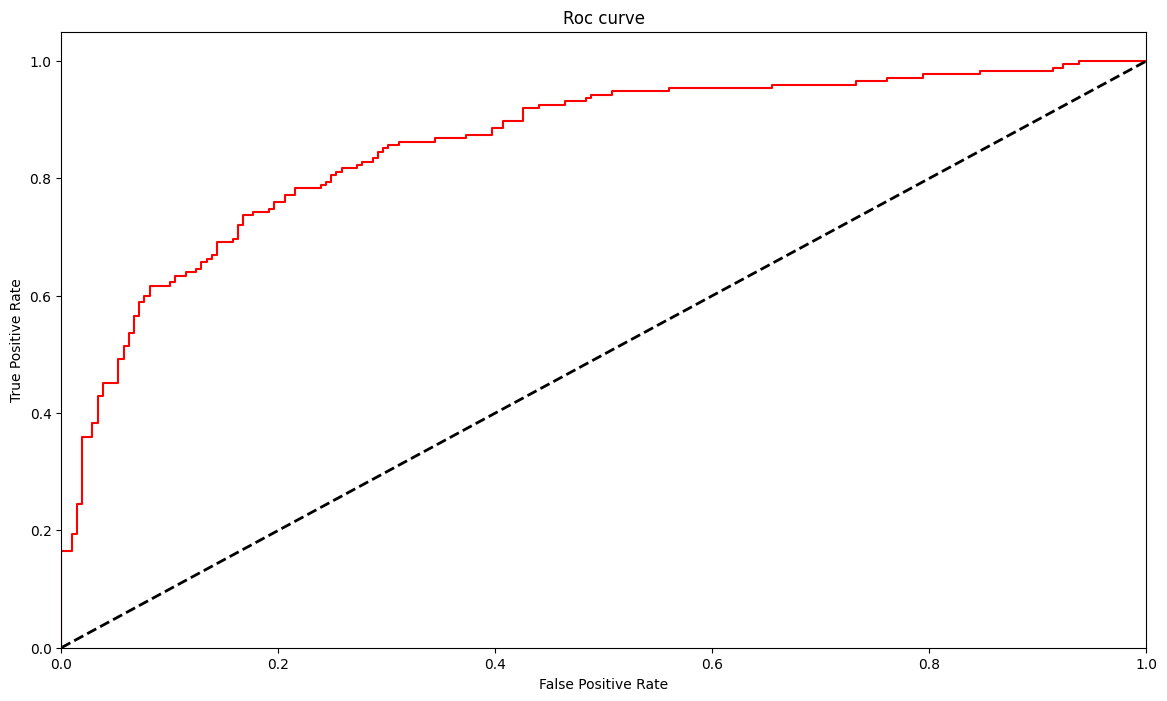

In [216]:
fpr, tpr = roc_svm
plt.figure(figsize=(14,8))
plt.plot(fpr, tpr, color="red")
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Roc curve')
plt.show()

# Test on new data

In [257]:
new_tweets = [
    'seharusnya masyarakat tidak perlu khawatir dengan adanya lockdown',
    'pemerintah harus segera menangani covid-19 dengan baik',
    'lockdown tidak akan menyelesaikan masalah covid-19',
]
le.inverse_transform(grid_svm.predict(new_tweets))

array(['pos', 'pos', 'neg'], dtype=object)